# Morphological Additive Decomposition
## Version Bastien

The decomposition explained in the paper *Classification of hyperspectral images by tensor modeling and additive morphological decomposition*, by Velasco-Forero, Angulo

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.morphology as skm

In [3]:
def OpenbyRec(input_im,SE=2):
    """Opening by Reconstruction.

    Arguments:
    input_im: numpy array.

    Returns:
    output_im: numpy array, containing reconstruction from eroded images.
    """
    im_mark = np.copy(input_im)
    im_mark = skm.opening(im_mark,skm.disk(SE)) #replaced erosion by opening
    out_im = skm.reconstruction(im_mark, input_im)
    return out_im

def ClosebyRec(input_im,SE=2):
    """Closing by Reconstruction

    Arguments:
    input_im: numpy array.

    Returns:
    output_im: numpy array, containing reconstruction from close images.
    """
    #c=np.max(input_im)
    #input_im=c-input_im
    im_mark = np.copy(input_im)
    im_mark = skm.closing(im_mark,skm.disk(SE)) 
    #im_mark = skm.opening(im_mark,skm.disk(SE)) #replaced erosion by opening
    out_im = skm.reconstruction(im_mark, input_im, method='erosion')
    #return c-out_im
    return out_im

def AdditiveDecomposition(input_im,levels=4,step=1):
    """Additive Decomposition by Reconstruction
    
    Arguments:
    input_im: numpy array.
    levels: number of levels in the decomposition.
    step: Discretization on the decomposition
    """
    RP=[]
    RN=[]
    SE=2
    #the following has been modified
    prev_ext = np.copy(input_im)
    prev_antiext = np.copy(input_im)
    for i in range(levels):
        tmp = ClosebyRec(input_im,SE)
        RP.append(tmp-prev_ext)
        prev_ext = np.copy(tmp)
        tmp = OpenbyRec(input_im,SE)
        RN.append(prev_antiext-tmp)
        prev_antiext=np.copy(tmp)
        SE=SE+step
    S = (prev_ext + prev_antiext)/2.
    return RP,RN,S

I modified the function so that they correspond to the AMD described in the paper.

Indeed, in the paper, the used morphological opearators are Openings/Closings by reconstruction, while the OpenbyRec and ClosebyRec functions that were implemented in the tuto were more sorts of Erosions/Dilatations by reconsctruction, that is reconstructions using erosions/dilatations as marker images, instead of opennings/closings. 

I also modified the AdditiveDecomposition function. Indeed, let us note $\gamma^{\infty}_{SE_i}$, respectively $\phi^{\infty}_{SE_i}$, the sequence of anti-extensive, respectively extensive, operators indexed by the size of the structuring element (openings, resp. closings, by reconstruction in the paper, erosions, resp. dilatations, by reconstruction in the tuto).

In the paper, we apply the following decomposition to the image $I$:

$$I = S + \frac{1}{2}\sum_{i=0}^{m-1}{R^{-}_i - R^+_i}$$
with $$R^+_i = \phi^{\infty}_{SE_i}(I) - \phi^{\infty}_{SE_{i-1}}(I)\\
R^-_i = \gamma^{\infty}_{SE_{i-1}}(I) - \gamma^{\infty}_{SE_i}(I) \\
\gamma^{\infty}_{SE_{-1}}(I) = \phi^{\infty}_{SE_{-1}}(I) = I\\
S = \frac{1}{2}\left(\phi^{\infty}_{SE_{m-1}}(I) + \gamma^{\infty}_{SE_{m-1}}(I) \right)$$
thanks to the idempotence and absoprtion law of openings and closings.

In the tuto, the implemented decomposition of the image $I$ is:
$$I = S + \sum_{i=0}^{m-1}{R^{-}_i - R^+_i} $$
with
$$R^+_i = f_{i-1}(I) - \gamma^{\infty}_{SE_i}(f_{i-1}(I))\\
R^-_i = f_{i}(I) - \gamma^{\infty}_{SE_i}(f_{i-1}(I)) \\
f_i(I)= \phi^{\infty}_{SE_i}\left(\gamma^{\infty}_{SE_i}(f_{i-1}(I))\right)\\
f_{-1}(I)=\gamma^{\infty}_{SE_{-1}}(I) = \phi^{\infty}_{SE_{-1}}(I) = I\\
S = f_{m-1}(I)$$

In [25]:
from skimage import data
from skimage.color import rgb2gray

I=data.camera()
RP,RN,S=AdditiveDecomposition(I,levels=10,step=2)

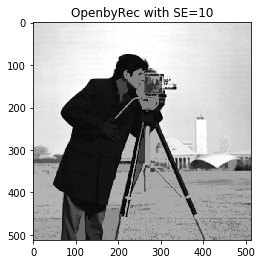

In [27]:
plt.imshow(OpenbyRec(I, SE=10),cmap='gray')
plt.title('OpenbyRec with SE=10')
plt.show()

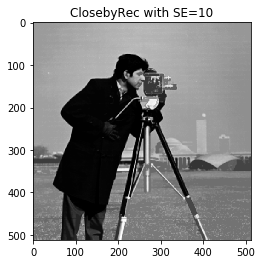

In [29]:
plt.imshow(ClosebyRec(I, SE=10),cmap='gray')
plt.title('ClosebyRec with SE=10')
plt.show()

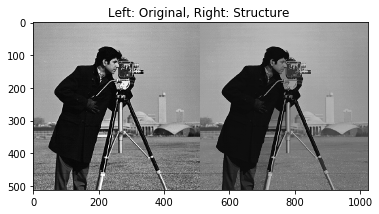

In [5]:
plt.imshow(np.concatenate([I,S],axis=1),cmap='gray')
plt.title('Left: Original, Right: Structure ')
plt.show()

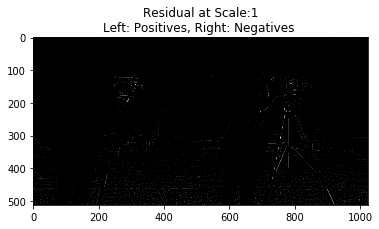

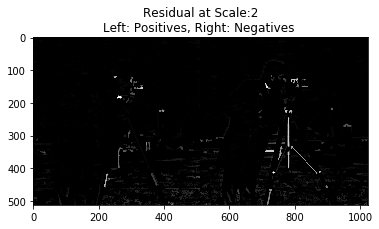

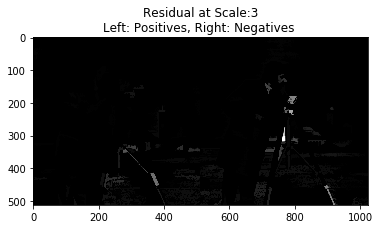

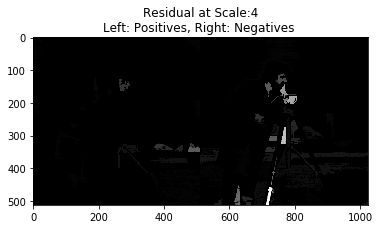

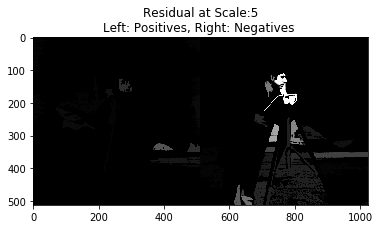

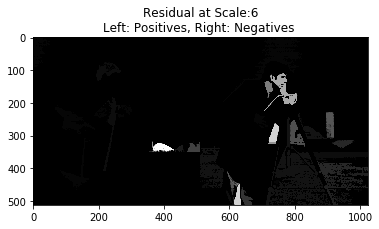

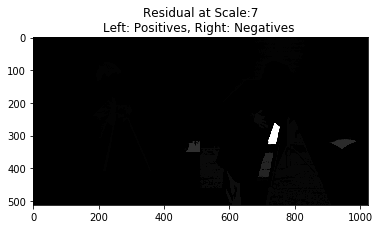

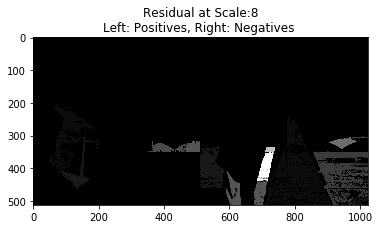

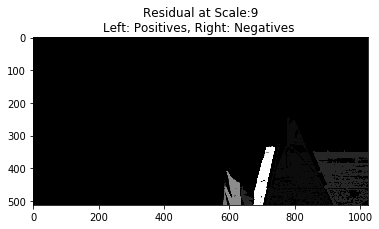

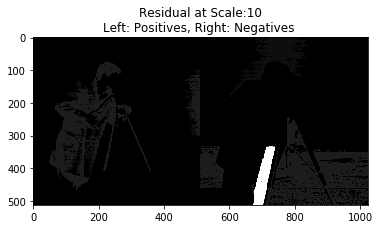

In [7]:
iteri=1
for Ri,Ri2 in zip(RP,RN):
    plt.imshow(np.concatenate([Ri,Ri2],axis=1),cmap='gray')
    plt.title('Residual at Scale:'+str(iteri)+'\nLeft: Positives, Right: Negatives ')
    plt.show()
    iteri+=1

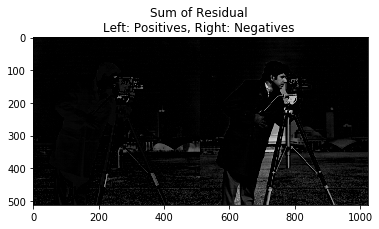

In [9]:
P=0
N=0
for Ri,Ri2 in zip(RP,RN):
    P=P+Ri
    N=N+Ri2
plt.imshow(np.concatenate([P,N],axis=1),cmap='gray')
plt.title('Sum of Residual \nLeft: Positives, Right: Negatives ')
plt.show()

In [11]:
rec = (N-P)/2. + S

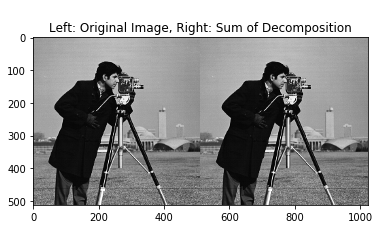

In [12]:
plt.imshow(np.concatenate([rec,I],axis=1),cmap='gray')
plt.title('\nLeft: Original Image, Right: Sum of Decomposition')
plt.show()

In [14]:
print('Is the decomposition exact?(It should be zero)',np.max(rec-I))

Is the decomposition exact?(It should be zero) 0.0


In [15]:
print('Is the decomposition exact?',np.alltrue(rec==I))

Is the decomposition exact? True


In [16]:
R = [(RN[i] - RP[i])/2 for i in range (len(RP))]

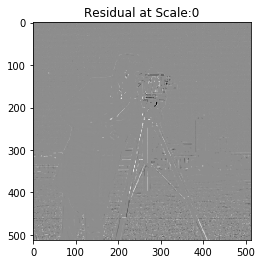

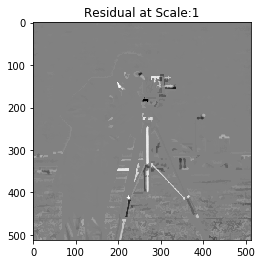

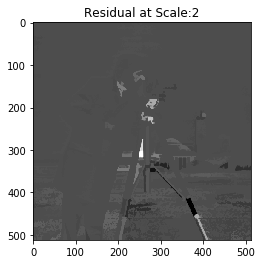

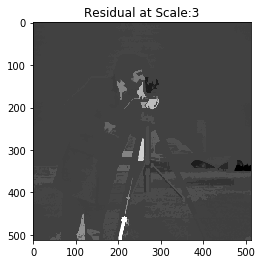

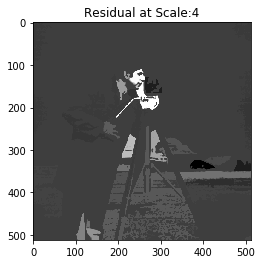

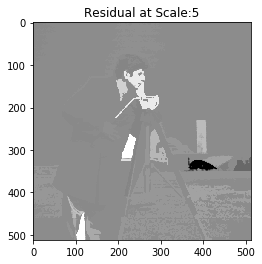

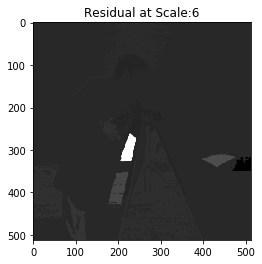

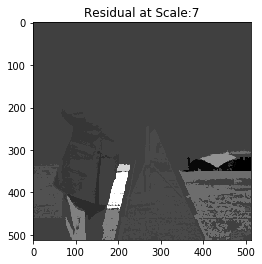

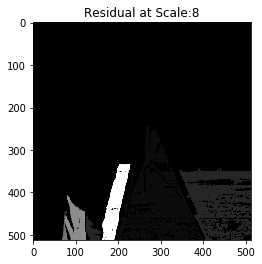

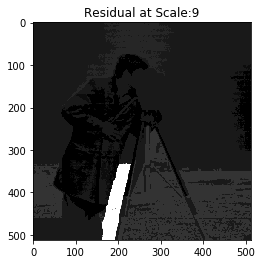

In [17]:
for iteri, Ri in enumerate(R):
    plt.imshow(Ri,cmap='gray')
    plt.title('Residual at Scale:'+str(iteri))
    plt.show()

In [18]:
R = np.array(R)

In [22]:
R = (np.array(RN) - np.array(RP))/2

In [23]:
rec = np.sum(R, axis=0) + S

In [24]:
print('Is the decomposition exact?',np.alltrue(rec==I))

Is the decomposition exact? True


### Difference with functions from tutorial

In [30]:
def OpenbyRec2(input_im,SE=2):
    """Opening by Reconstruction.

    Arguments:
    input_im: numpy array.

    Returns:
    output_im: numpy array, containing reconstruction from eroded images.
    """
    im_mark = np.copy(input_im)
    im_mark = skm.erosion(im_mark,skm.disk(SE))
    out_im = skm.reconstruction(im_mark, input_im)
    return out_im

def ClosebyRec2(input_im,SE=2):
    """Closing by Reconstruction

    Arguments:
    input_im: numpy array.

    Returns:
    output_im: numpy array, containing reconstruction from close images.
    """
    c=np.max(input_im)
    input_im=c-input_im
    im_mark = np.copy(input_im)
    im_mark = skm.erosion(im_mark,skm.disk(SE))
    out_im = skm.reconstruction(im_mark, input_im)
    return c-out_im

In [31]:
openByRecs1 = np.array([OpenbyRec(I, SE=i*2) for i in range(1,11)])
openByRecs2 = np.array([OpenbyRec2(I, SE=i*2) for i in range(1,11)])
closeByRecs1 = np.array([ClosebyRec(I, SE=i*2) for i in range(1,11)])
closeByRecs2 = np.array([ClosebyRec2(I, SE=i*2) for i in range(1,11)])

In [32]:
print(np.all(openByRecs1==openByRecs2))
print(np.all(closeByRecs1==closeByRecs2))

True
True


In [42]:
11/(145**2)*100

0.052318668252080855

Both functions are the same !